In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib as mpl
import matplotlib.cm as cm
import shap
from xgboost import XGBRegressor
import joblib

In [ ]:
file_path = r"../dataset/BCN_GrafVial_With_Tmrt.csv"
df = pd.read_csv(file_path)

print("Dataset Shape:", df.shape)

print("\nColumn Names:")
print(df.columns.tolist())

print("\nData Types:")
print(df.dtypes)

print("\nFirst 5 Rows:")
print(df.head())

print("\nMissing Values Per Column:")
print(df.isna().sum())

print("\nSummary Statistics (numeric only):")
print(df.describe())

In [35]:
# Drop rows where target is missing
df = df.dropna(subset=['Tmrt_Buffer_Mean'])

In [36]:
# Feature engineering
df['Aspect_Ratio'] = df['BuildingHeight_Mean'] / df['Street_Buffer']
df['Height_Diff'] = (df['BuildingHeight_Right'] - df['BuildingHeight_Left']).abs()
df['Tree_Density'] = df['Number_of_Trees'] / df['Street_Buffer']
df['Relative_Canopy'] = df['Total_Canopy_Area_m2'] / df['Street_Buffer']
df['Tree_Height_Ratio'] = df['Mean_Tree_Height'] / (df['BuildingHeight_Mean'] + 1e-6)

In [ ]:
# Original features
selected_features = [    
    'BuildingHeight_Mean',
    'Street_Buffer',
    'Number_of_Trees',
    'Mean_Tree_Height',
    'Total_Canopy_Area_m2',
    #'ANGLE_sin',
    #'ANGLE_cos',
    'ANGLE_rad',
    # 'BuildingHeight_Right',
    # 'BuildingHeight_Left',
    'Aspect_Ratio',
    'Height_Diff',
    'Tree_Density',
    'Relative_Canopy',
    'Tree_Height_Ratio',
    # 'StreetBuffer_cos',
    # 'StreetBuffer_sin',
    'Tmrt_Buffer_Mean',
    #'Tmrt_Buffer_Min',
    #'Tmrt_Buffer_Max',
    #'Tmrt_Buffer_Std',
    #'Tmrt_Buffer_Median',
    #'Tmrt_Buffer_Count'
]

df_selected = df[selected_features]

df_selected = df_selected.apply(pd.to_numeric, errors='coerce').dropna()


print("Cleaned dataset shape:", df_selected.shape)
print("\n Columns included:")
print(df_selected.columns.tolist())
print("\n First 5 rows:")
print(df_selected.head())

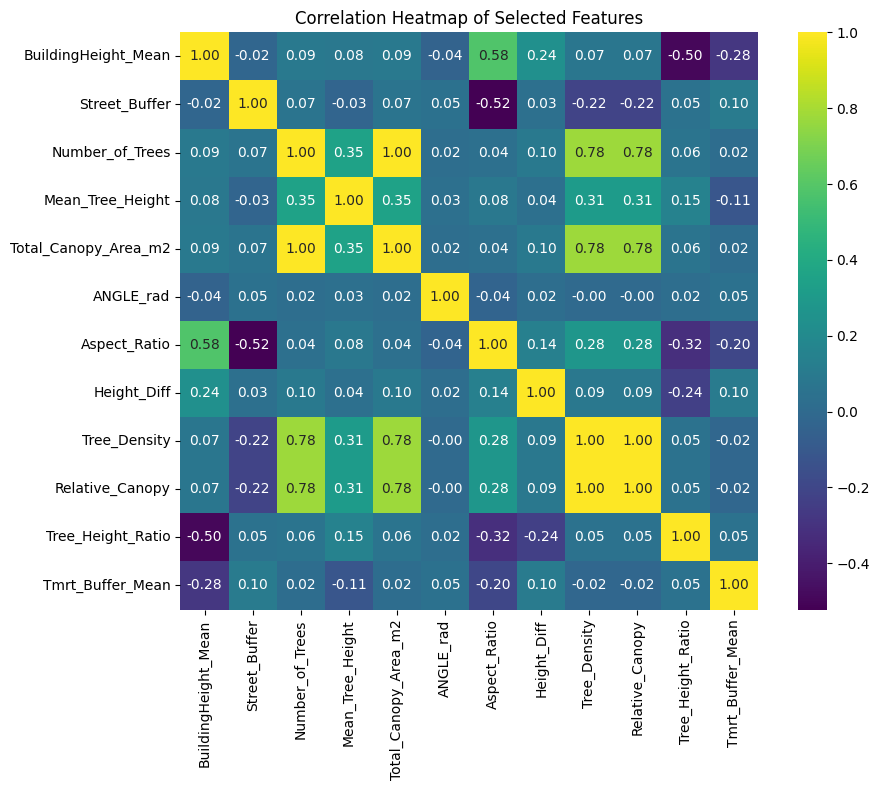

In [38]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_selected.corr(), annot=True, fmt=".2f", cmap="viridis", square=True)
plt.title("Correlation Heatmap of Selected Features")
plt.tight_layout()
plt.show()

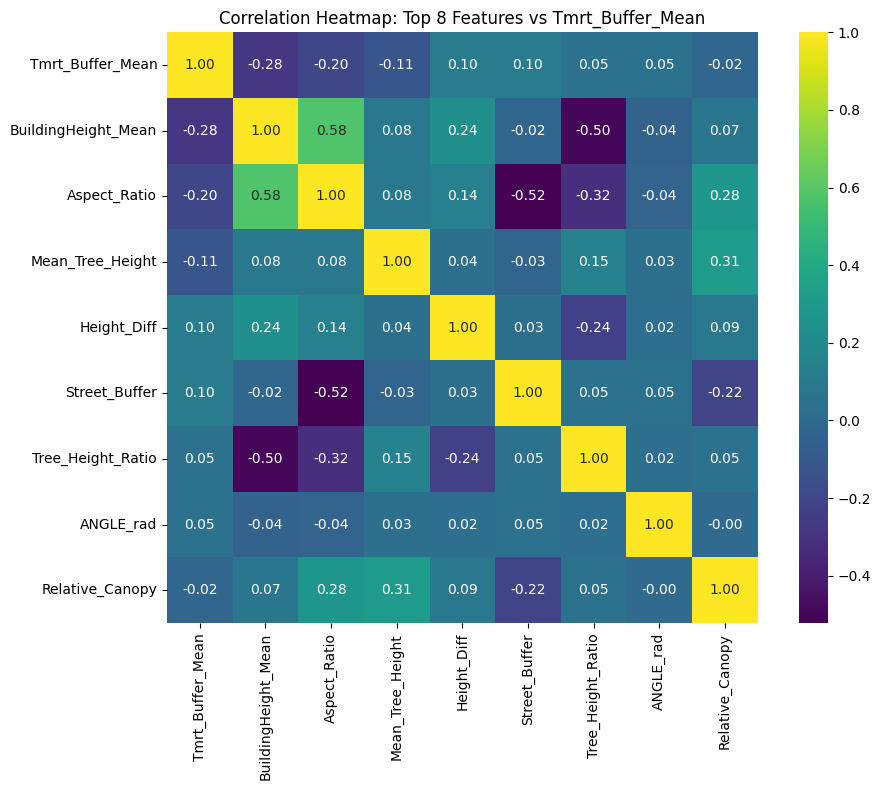

In [39]:
# Compute correlations with target
target = 'Tmrt_Buffer_Mean'
correlations = df_selected.corr()[target].drop(target)

# Get top 8 absolute correlations
top_features = correlations.abs().sort_values(ascending=False).head(8).index.tolist()

# Include the target itself in the heatmap
top_features_with_target = [target] + top_features

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_selected[top_features_with_target].corr(), 
            annot=True, fmt=".2f", cmap="viridis", square=True)
plt.title(f"Correlation Heatmap: Top 8 Features vs {target}")
plt.tight_layout()
plt.show()

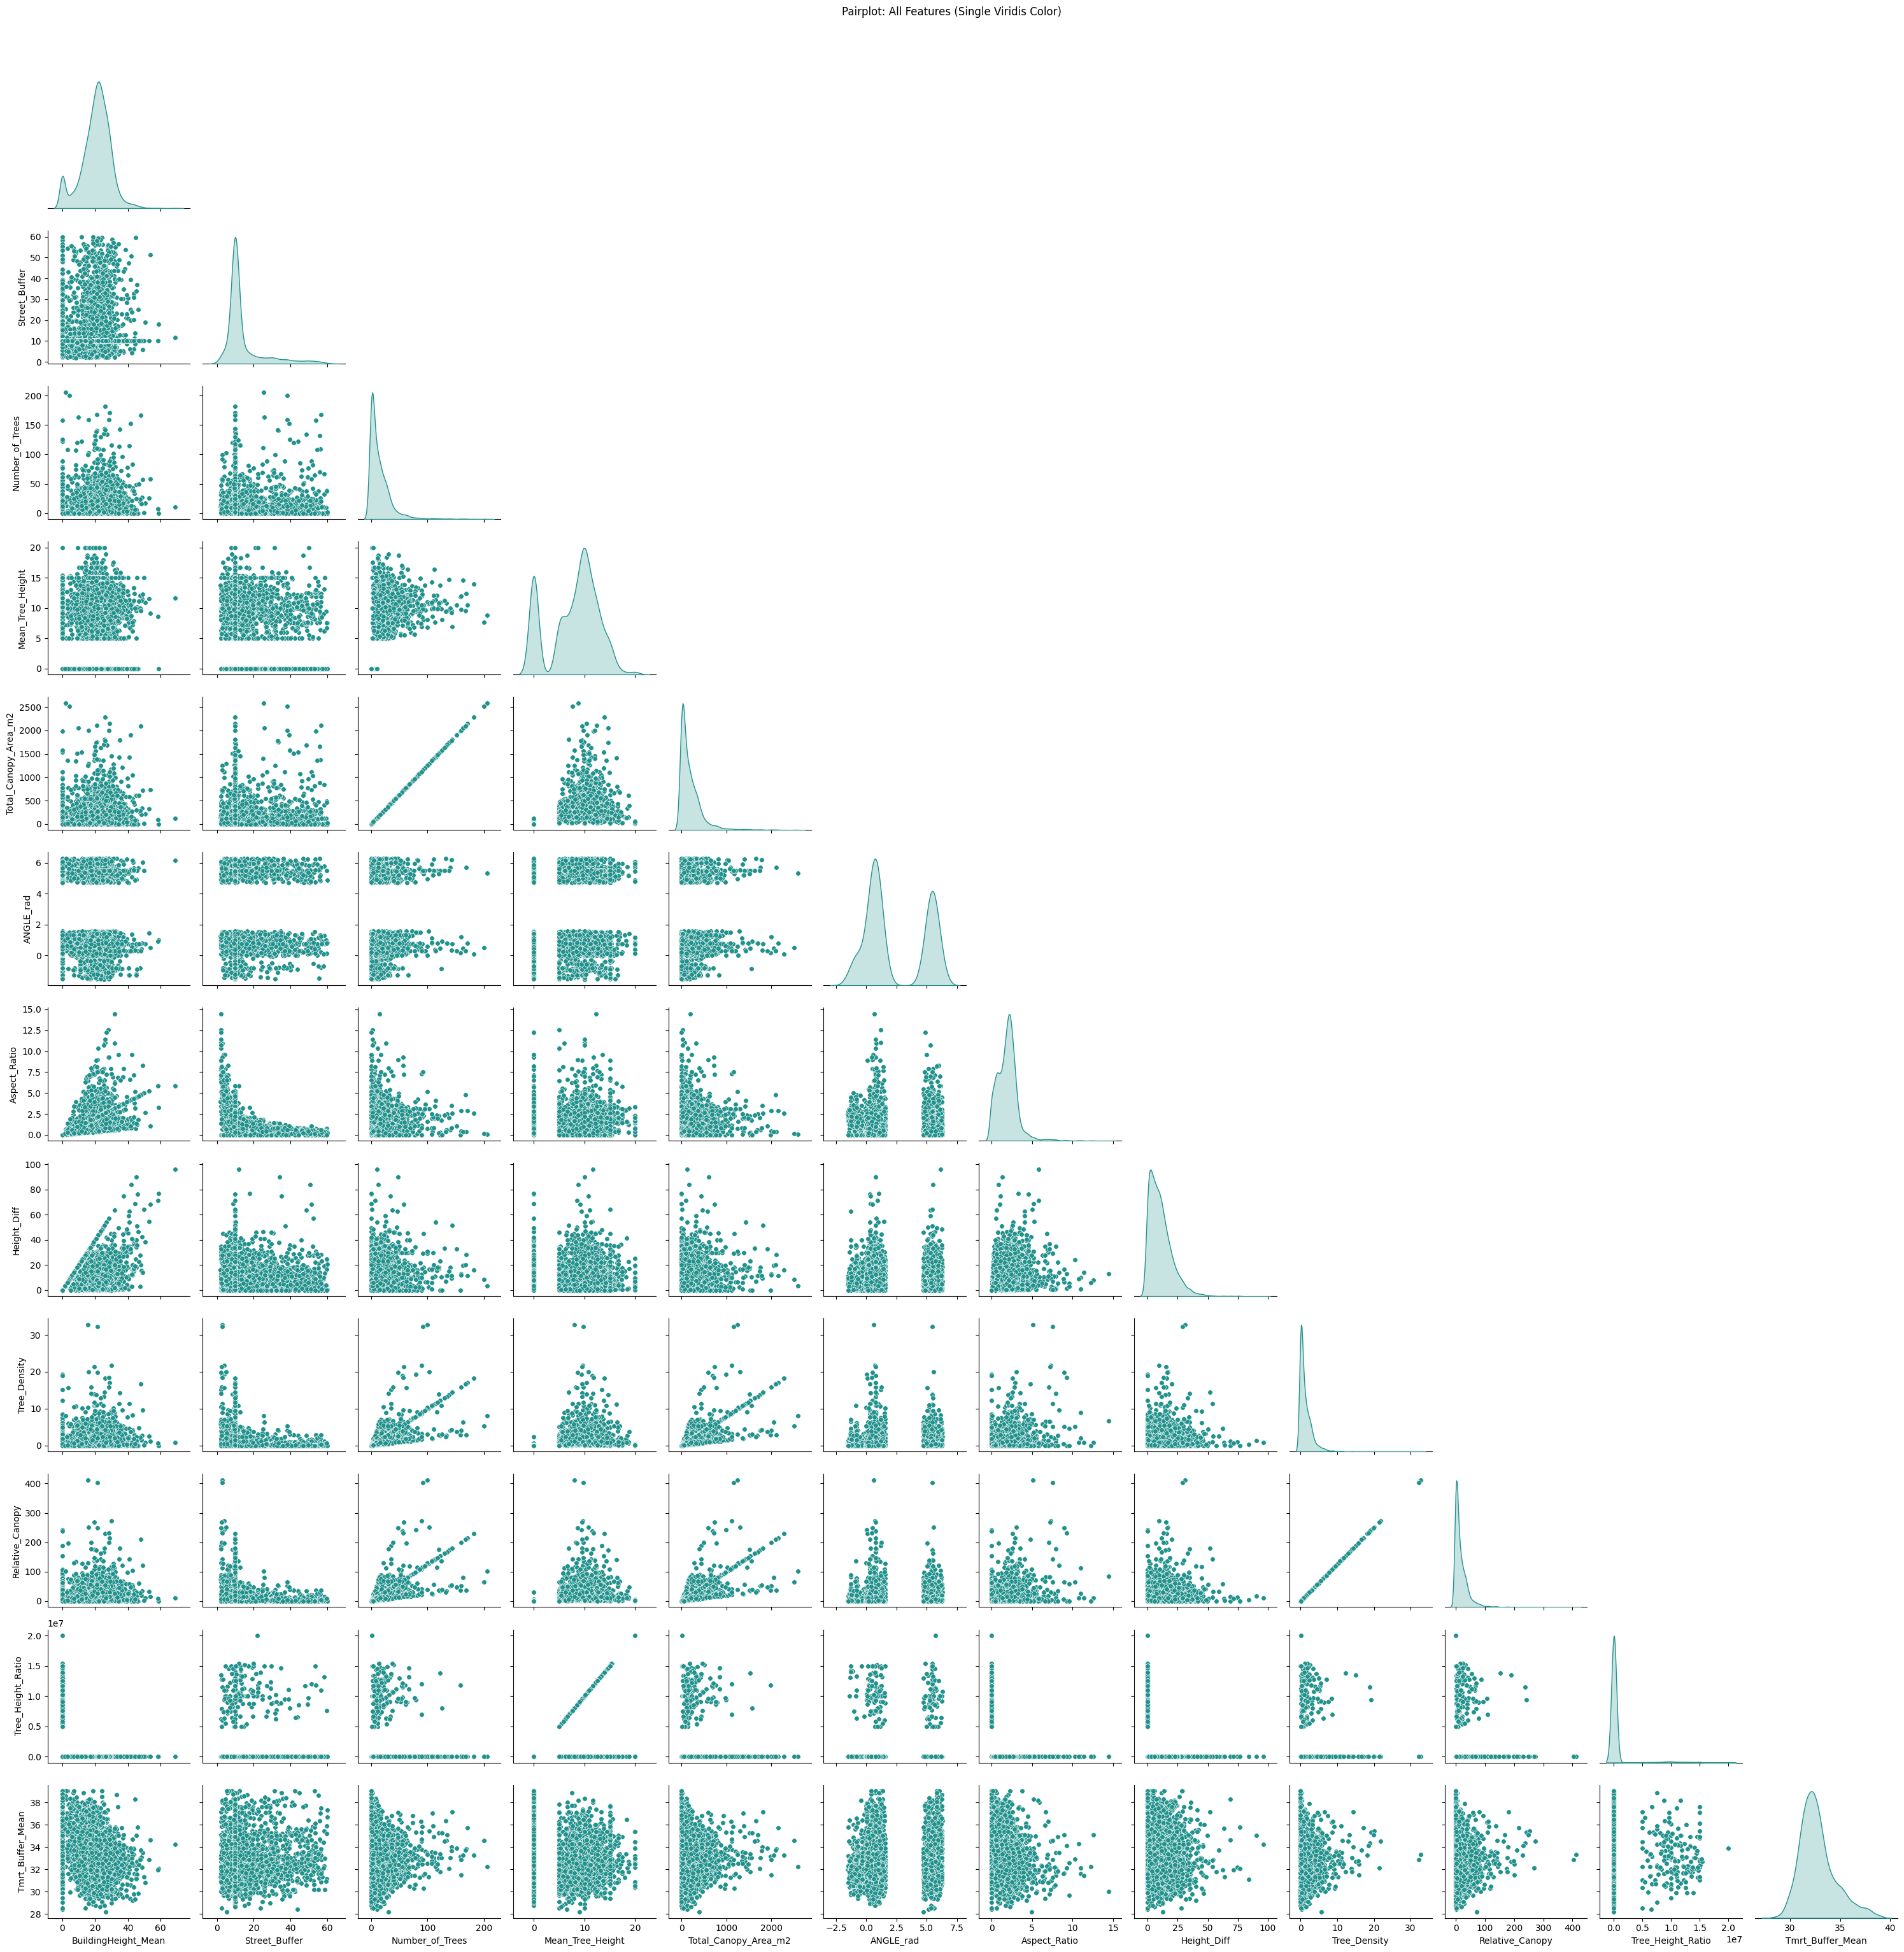

In [40]:
viridis_color = plt.colormaps["viridis"](0.5)

# Build pairplot
g = sns.pairplot(
    df_selected,
    diag_kind='kde',
    corner=True,
    plot_kws={'s': 30, 'edgecolor': 'white', 'color': viridis_color},
    diag_kws={'color': viridis_color}
)

plt.suptitle("Pairplot: All Features (Single Viridis Color)", y=1.02)
plt.tight_layout()
plt.show()


Top 4 correlated features: ['BuildingHeight_Mean', 'Aspect_Ratio', 'Mean_Tree_Height', 'Height_Diff']


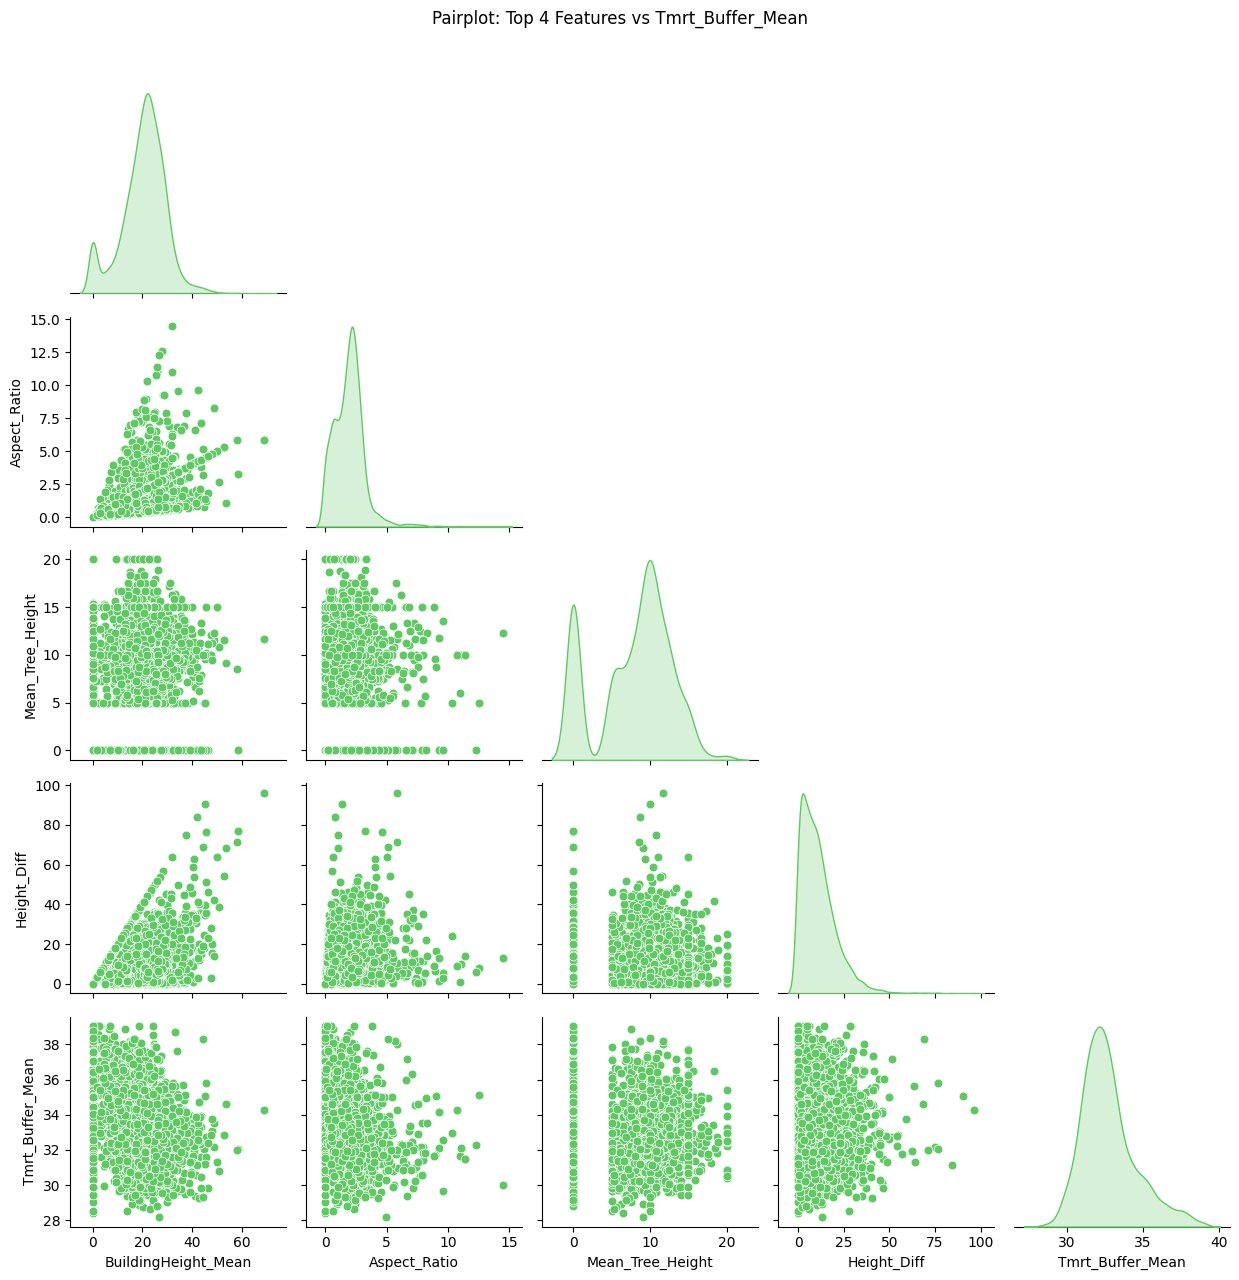

In [43]:
# Find top 4 correlated features
corr = df_selected.corr()
top_corr = corr['Tmrt_Buffer_Mean'].drop('Tmrt_Buffer_Mean').abs()
top_4_features = top_corr.sort_values(ascending=False).head(4).index.tolist()
print("\nTop 4 correlated features:", top_4_features)

df_top4 = df_selected[top_4_features + ['Tmrt_Buffer_Mean']]

viridis_color = plt.colormaps["viridis"](0.75)

g = sns.pairplot(
    df_top4,
    diag_kind='kde',
    corner=True,
    plot_kws={'s': 40, 'edgecolor': 'white', 'color': viridis_color},
    diag_kws={'color': viridis_color}
)

plt.suptitle("Pairplot: Top 4 Features vs Tmrt_Buffer_Mean", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Normalize Features
X = df_selected.drop(columns='Tmrt_Buffer_Mean')
y = df_selected['Tmrt_Buffer_Mean']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df['Tmrt_Buffer_Mean'] = y.values

print("\nNormalized Features Preview:")
print(X_scaled_df.head())

Regression model

In [45]:
X = X_scaled_df.drop(columns='Tmrt_Buffer_Mean')
y = X_scaled_df['Tmrt_Buffer_Mean']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n MAE: {mae:.2f}")
print(f" R² Score: {r2:.2f}")



 MAE: 1.26
 R² Score: 0.12


Random Forest

In [46]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest MAE: {mae_rf:.2f}")
print(f"Random Forest R²: {r2_rf:.2f}")


Random Forest MAE: 1.11
Random Forest R²: 0.27


In [ ]:
# Compute importances
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values()


viridis = cm.get_cmap('viridis')
single_color = viridis(0.85) 

plt.figure(figsize=(10, 10))
importances_sorted.plot(kind='barh', color=single_color)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title("Feature Importance (Random Forest)", fontsize=14)
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

XGBoost

XGBoost MAE: 1.07
XGBoost R²: 0.31


<Figure size 600x600 with 0 Axes>

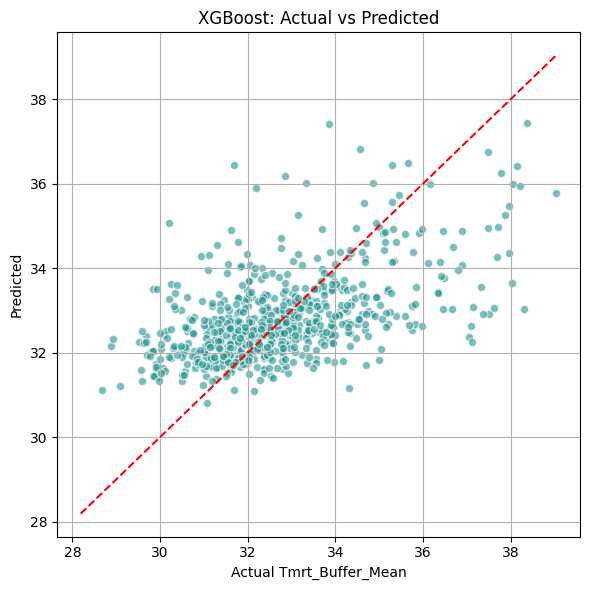

In [55]:
df = df[selected_features].apply(pd.to_numeric, errors='coerce').dropna()

# Features and target
X = df.drop(columns='Tmrt_Buffer_Mean')
y = df['Tmrt_Buffer_Mean']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost MAE: {mae:.2f}")
print(f"XGBoost R²: {r2:.2f}")

plt.figure(figsize=(6, 6))

viridis_color = plt.colormaps["viridis"](0.5)

plt.figure(figsize=(6, 6))
plt.scatter(
    y_test,
    y_pred,
    alpha=0.6,
    color=viridis_color,
    edgecolor="white"
)

plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')

plt.xlabel("Actual Tmrt_Buffer_Mean")
plt.ylabel("Predicted")
plt.title("XGBoost: Actual vs Predicted")

plt.grid(True)
plt.tight_layout()
plt.show()

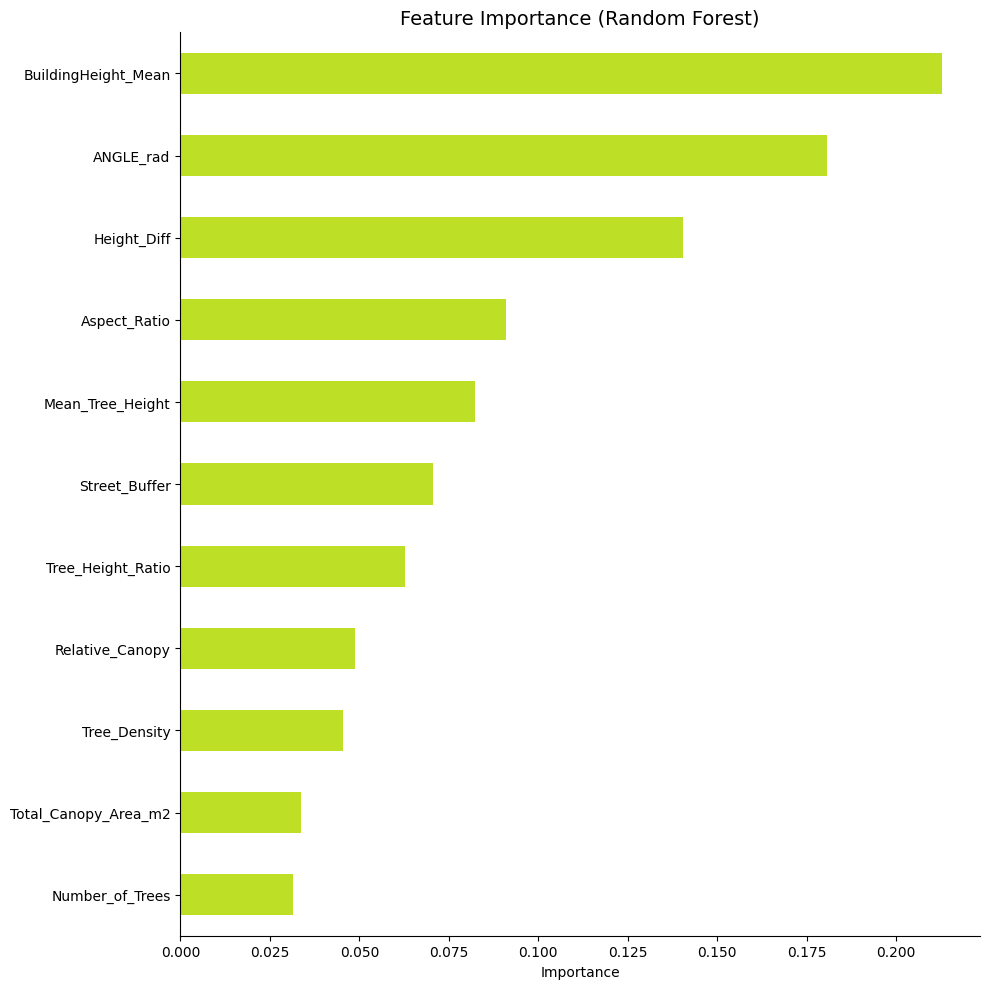

In [65]:
importances = xgb_model.feature_importances_
feature_names = X.columns

# Sort by importance
sorted_idx = np.argsort(importances)

# Pick a single Viridis color
viridis_color = plt.colormaps["viridis"](0.9)

plt.figure(figsize=(10, 10))
importances_sorted.plot(kind='barh', color=viridis_color)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title("Feature Importance (Random Forest)", fontsize=14)
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

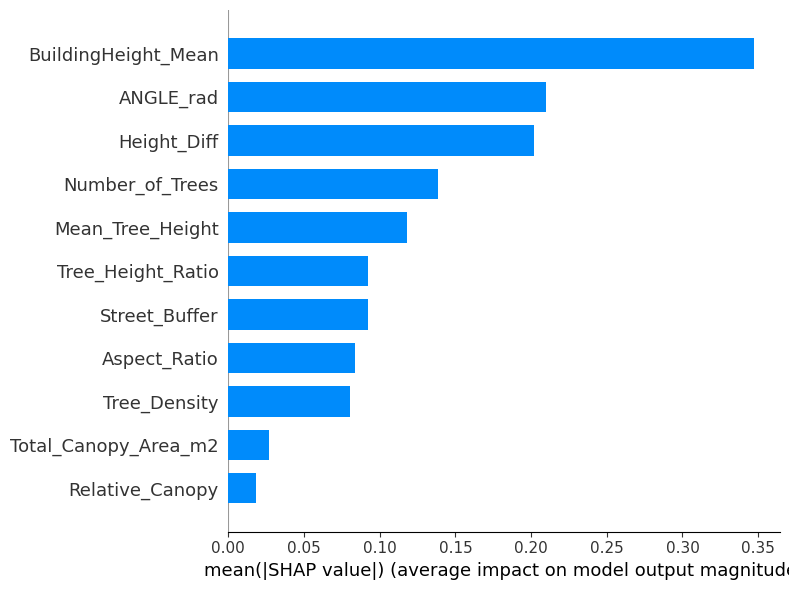

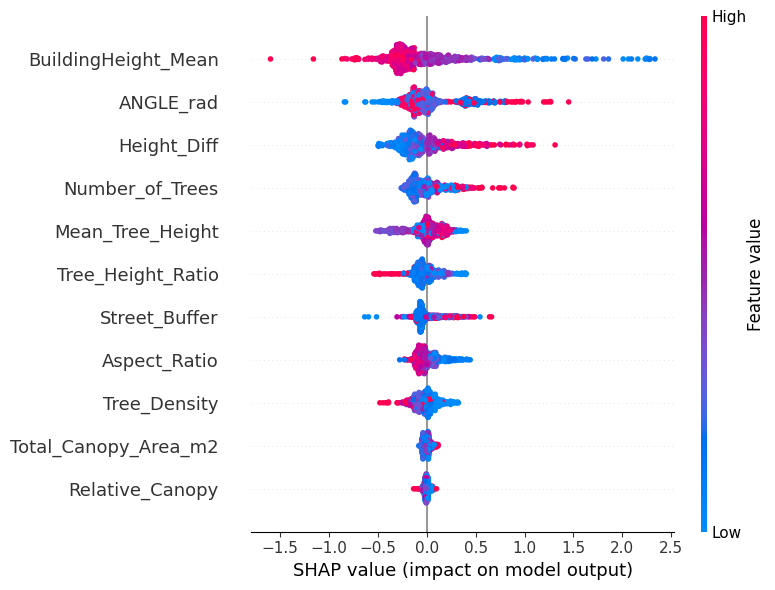

<Figure size 800x600 with 0 Axes>

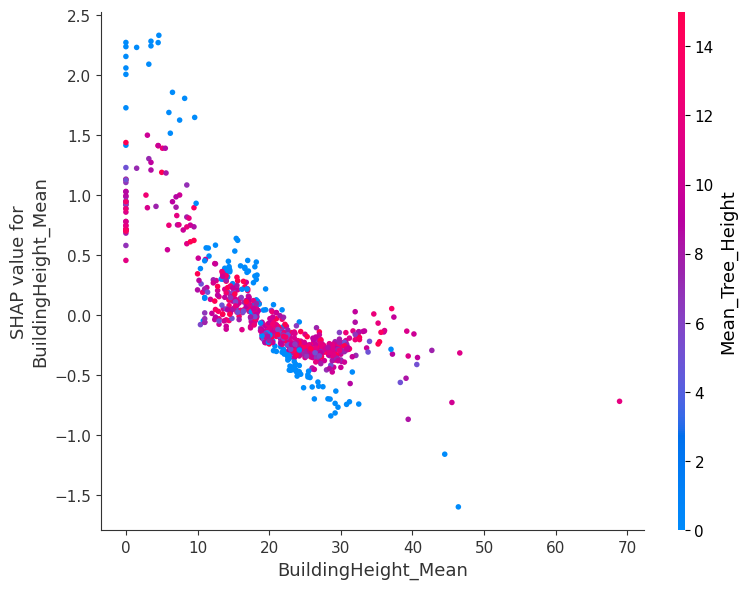

In [66]:
# SHAP Explainer
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

plot_size = (8, 6)

# SHAP Summary Plot
plt.figure(figsize=plot_size)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.gcf().set_size_inches(plot_size)
plt.tight_layout()
plt.show()

# SHAP Beeswarm Plot
plt.figure(figsize=plot_size)
shap.summary_plot(shap_values, X_test, show=False)
plt.gcf().set_size_inches(plot_size)
plt.tight_layout()
plt.show()

# SHAP Dependence Plot
plt.figure(figsize=plot_size)
shap.dependence_plot("BuildingHeight_Mean", shap_values.values, X_test, show=False)
plt.gcf().set_size_inches(plot_size)
plt.tight_layout()
plt.show()

In [ ]:
top_n = 5
shap_importances = np.abs(shap_values.values).mean(axis=0)
top_indices = np.argsort(shap_importances)[-top_n:][::-1]
top_features = X_test.columns[top_indices]

for feature in top_features:
    shap.dependence_plot(feature, shap_values.values, X_test, show=False)
    plt.title(f"SHAP Dependence: {feature}")
    plt.tight_layout()
    
    plt.show()

In [ ]:
model_path = r"../dataset/xgboost_tmrt_model.joblib"
joblib.dump(xgb_model, model_path)
print(f" Model saved to: {model_path}")